**write down at the beginning:**

This is the final summay and merge of the code for my first paper *Right on Tracks? Identifying the spatial-temporal patterns of campus running activities and its resilience towards to pandemic response intervention
'*

Please write comments thoroughly and carefully and organize the code scientifically

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# ignore warings of notebook

In [2]:
# import modules

import scipy.cluster.vq as scv
from PIL import Image
import numpy as np
from scipy import misc

import pandas as pd
import geopandas as gpd
import statsmodels.formula.api as smf
import itertools
from shapely.geometry import Point, Polygon, LineString

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# %matplotlib inline
# %config InlineBackend.figure_format='retina'

import datetime

from tqdm import tqdm
import os

In [3]:
import time

In [4]:
import seaborn as sns

In [5]:
# 读取程序开始时间
start_time = datetime.datetime.now()
start_time

datetime.datetime(2022, 10, 17, 22, 37, 42, 998701)

In [6]:
# dataset import

# 清华边界数据
thu_gdf = gpd.read_file('../../202203_Campus/03_data/GIS/tsinghua.shp')
thu_gdf.crs = 'epsg:4326'
campus_columns = ['built_area','num_bldg','building_a','OSM_area','other_tags','landuse_ar','leisure_ar','natural_ar','tourism_ar','amenity_ar','sport_area','place_area','shop_area','office_are','barrier_ar','man_made_a']

In [7]:
# 读取需要导入的shp列表
dirnameslst = []
for dirpath,dirnames,filenames in os.walk('../../202204_keepdata/03_data/keep_data_bj/'):
    if dirnames:
        dirnameslst = dirnames

In [8]:
# 按照其一文件写表头
keep_gdf = gpd.GeoDataFrame(data = None, columns = gpd.read_file('../../202204_keepdata/03_data/keep_data_bj/keep_05_16' + '/new_keep_gdf_all.shp').columns)
gdf_list = []

# 读取数据
for i in tqdm(dirnameslst):
    gdf = gpd.read_file('../../202204_keepdata/03_data/keep_data_bj/' + str(i) + '/new_keep_gdf_all.shp')
    gdf['date'] = '2022/' + str(i.split('_')[1]).zfill(2) + '/' + str(i.split('_')[2]).zfill(2)
    gdf_list.append(gdf)

# 合并
for i in tqdm(gdf_list):
    keep_gdf = keep_gdf.append(i)

keep_gdf = keep_gdf.reset_index(drop=True)
keep_gdf.crs = 'epsg:4326' # 设置crs

100%|███████████████████████████████████████████| 120/120 [00:28<00:00,  4.26it/s]


In [9]:
### 接下来整合清华范围的格网和keep数据进行分析
sjoin_within = gpd.sjoin(keep_gdf, thu_gdf, op='within')[['start_time','end_time','start','end','date','geometry']]
sjoin_intersects = gpd.sjoin(keep_gdf, thu_gdf, op='intersects')[['start_time','end_time','start','end','date','geometry']]


In [10]:
print('原始数据轨迹数：'+ str(keep_gdf.shape[0]))
print('清华校内within轨迹数：'+ str(sjoin_within.shape[0]))
print('清华校内intersects轨迹数：'+ str(sjoin_intersects.shape[0]))

原始数据轨迹数：2289085
清华校内within轨迹数：12237
清华校内intersects轨迹数：18850


In [2]:
import time, datetime
start_time = datetime.datetime.now()
time.sleep(10)
end_time = datetime.datetime.now()
time.mktime(end_time - start_time)

TypeError: Tuple or struct_time argument required

In [11]:
(end_time - start_time).seconds

10

In [11]:
# 写入时间（换一种方式——把start和end转化为格林威治时间）
# input: df GeoDataFrame/ [{date:STR'%Y/%m/%d',start:INT,end:INT,geometry:LineString}]
# output: 'start_g', 'end_g'
def wtimestamp(df):
    for i in tqdm(df.index):
        ## 提取对应的month的str
        date_str_lst = df.loc[i,'date'].split('/')

        # 时间字符串转datetime对象，再转时间戳
        date_str = date_str_lst[0] + '-' + date_str_lst[1] + '-01 00:00:00'
        timeArray = time.strptime(date_str, "%Y-%m-%d %H:%M:%S")
        date_stamp = int(time.mktime(timeArray))
        df.loc[i,'start_g'] = df.loc[i,'start'] - 24*3600 + date_stamp
        df.loc[i,'end_g'] = df.loc[i,'end'] - 24*3600 + date_stamp
        
    return df

sjoin_intersects_copy = wtimestamp(sjoin_intersects)


100%|█████████████████████████████████████| 18850/18850 [00:10<00:00, 1748.93it/s]


In [12]:
# 去重复与合并

def derepeat(df):
    df['str_geometry'] = df['geometry'].astype(str)
    df_ = df.groupby('str_geometry').count()
    repeated_lst = df_[df_['start_g'] > 1].index
    df_repeated = df[df['str_geometry'].isin(repeated_lst)]



    lst = []
    ilst = []
    for i in tqdm(df_repeated.index):
        if df_repeated.loc[i,'geometry'] not in lst:
            df_repeated.loc[i,'flag'] = 0
            lst.append(df.loc[i,'geometry'])
            ilst.append(i)
        elif df_repeated.loc[i,'geometry'] in lst:
            df_repeated.loc[i,'flag'] = 1
            j = ilst[lst.index(df.loc[i,'geometry'])]
            df_repeated.loc[j,'start_g'] = min([df_repeated.loc[j,'start_g'],df_repeated.loc[i,'start_g']])
            df_repeated.loc[j,'end_g'] = max([df_repeated.loc[j,'end_g'],df_repeated.loc[i,'end_g']])
            lst.remove(df.loc[j,'geometry'])
            ilst.remove(j)

    # 把df_repeated合并替换回df中

    df_repeated_copy = df_repeated[df_repeated['flag']==0][['start_g','end_g','geometry']]

    a = df_repeated_copy
    b = df[~(df['str_geometry'].isin(repeated_lst))][['start_g','end_g','geometry']]
    df_output = pd.concat([ a , b ]).sort_index()
    
    return df_output

sjoin_intersects = derepeat(sjoin_intersects_copy)

100%|█████████████████████████████████████████| 3350/3350 [02:17<00:00, 24.40it/s]


In [13]:
# 判别边界类型
sjoin_intersects['sjointype'] = 'intersects'

for i in tqdm(sjoin_intersects.index):
    if i in sjoin_within.index:
        sjoin_intersects.loc[i,'sjointype'] = 'within'

100%|█████████████████████████████████████| 17175/17175 [00:03<00:00, 4718.46it/s]


In [14]:
def pair(list):
        for i in range(1, len(list)):
            yield list[i-1],list[i]
            
def keepclean(gdf,maxspeed):
    df_clean = gdf.reset_index()
    df_clean_copy = df_clean.to_crs('epsg:4509')
    df_clean_copy['duration_seconds'] = df_clean_copy.end_g - df_clean_copy.start_g
    df_clean_copy = df_clean_copy[df_clean_copy['duration_seconds'] > 0]
    df_clean_copy.reset_index(inplace = True)
    
    
    max_list = [] # 
    df_count = 0
    for i in tqdm(df_clean_copy.geometry):
        test_list = list(i.coords)
        a_float = [] # 创建用于储存分段长度的列表
        k = 0 # 分段的index
        for pt1,pt2 in pair(test_list):
            a_float.append(LineString([pt1,pt2]).length)
            k = k + 1
            
        b_float = a_float
        for i in range(0,len(a_float)-1,1):
            a_float[i] = sum(b_float[np.max([0,i-2]):np.min([len(b_float)-1,i+3])]) / len(b_float[np.max([0,i-2]):np.min([len(b_float)-1,i+3])]) # 滑动平均
    
        df_clean_copy.loc[df_count,'max_length'] = max(a_float) #取得最大值
        df_clean_copy.loc[df_count,'count_time'] = k # 计数
        max_list.append(max(a_float))
        df_count = df_count + 1

    df_clean_copy['max_speed'] = df_clean_copy['max_length'] * df_clean_copy['count_time'] / df_clean_copy['duration_seconds']

    df_clean_copy_clear = df_clean_copy.drop(df_clean_copy[df_clean_copy['max_speed']>maxspeed].index)
    df_clean_clear = df_clean_copy_clear.to_crs('epsg:4509')

    keep_gdf_clean = df_clean_copy_clear.to_crs('epsg:4326')

#     keep_gdf_clean['starttime_hour'] = (keep_gdf_clean.start - keep_gdf_clean.start.min()) / 3600
#     keep_gdf_clean.starttime_hour.hist(bins=20, edgecolor='black', grid=False)
#     plt.xlabel('Time of day(Hour)')
#     plt.ylabel('Sample Density')
    
    # 整理columns
    # a = ['index','date','start_time', 'end_time', 'start', 'end', 'duration_seconds', 'max_length', 'count_time', 'max_speed', 'sjointype', 'geometry']
    # keep_gdf_clean = keep_gdf_clean[a]

    return keep_gdf_clean

In [15]:
# rout clean
sjoin_intersects = keepclean(sjoin_intersects,10) ## 按照博尔特计算最快速度10m/s


100%|██████████████████████████████████████| 17158/17158 [02:24<00:00, 118.41it/s]


In [16]:
sjoin_intersects['start_datetime'] = pd.to_datetime(sjoin_intersects['start_g'].apply(lambda x : time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(x))))
sjoin_intersects['end_datetime'] = pd.to_datetime(sjoin_intersects['end_g'].apply(lambda x : time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(x))))

In [17]:
keep_gdf = sjoin_intersects[sjoin_intersects['sjointype'].isin(['within','within36'])][['sjointype','start_g','end_g','start_datetime','end_datetime','geometry']]


In [18]:
keep_gdf_copy = sjoin_intersects[sjoin_intersects['sjointype'].isin(['within','within36'])]


In [132]:
sjoin_intersects.sjointype.value_counts()

within        10907
intersects     5750
Name: sjointype, dtype: int64

<AxesSubplot:>

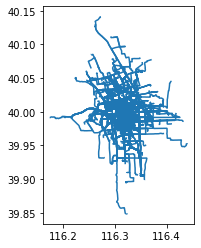

In [134]:
sjoin_intersects[sjoin_intersects.sjointype =='intersects'].plot()

# id

In [20]:
# 加id
keep_gdf['trid'] = keep_gdf.index
keep_gdf = keep_gdf[['trid','sjointype','start_g','end_g','start_datetime','end_datetime','geometry']]


<AxesSubplot:title={'center':'Running Routes in THU campus (alpha = 0.01)'}>

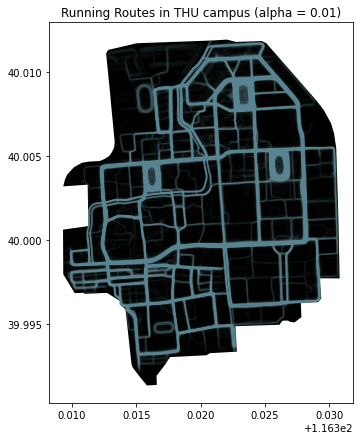

In [21]:
# Routes Viz: with the dencity showed by alpha linestrings
ax = thu_gdf.plot(figsize = (7,7),color = 'black')
plt.title('Running Routes in THU campus (alpha = 0.01)')
keep_gdf[keep_gdf['sjointype'] == 'within'].plot(ax =ax,color = 'lightblue',alpha = 0.01,)

In [22]:
# 计算指标

In [23]:
def add_columns(df):

    for i in tqdm(df.index):
        start_point = df.loc[i].geometry.coords[0]
        df.loc[i, 'start_latitude'] = start_point[1]
        df.loc[i, 'start_longitude'] = start_point[0]

        end_point = df.loc[i].geometry.coords[-1]
        df.loc[i, 'end_latitude'] = end_point[1]
        df.loc[i, 'end_longitude'] = end_point[0]

    # crs change
    df.crs = 'epsg:4326'
    df_copy = df.to_crs('epsg:4509')
    df['pathlength'] = df_copy.geometry.length
    
    df['duration'] = df['end_datetime']-df['start_datetime']

    df['duration_minutes'] = df.index.map(lambda i: divmod(df['duration'][i].total_seconds(), 60)[0])

    return df

In [24]:
keep_gdf = add_columns(keep_gdf)

100%|██████████████████████████████████████| 10907/10907 [00:13<00:00, 810.00it/s]


In [25]:
#points in epsg:4506
keep_gdf['points'] = keep_gdf.to_crs('epsg:4506').apply(lambda x: [y for y in x['geometry'].coords], axis=1)
print('1')
#points in epsg:4326
keep_gdf['points4326'] = keep_gdf.to_crs('epsg:4326').apply(lambda x: [y for y in x['geometry'].coords], axis=1)
print('1')
# paths
keep_gdf['paths'] = keep_gdf['points'].apply( lambda x: [ LineString([pt1,pt2]) for pt1,pt2 in pair(x) ] )
print('1')
# 由GPS信号点表现的点距时间
keep_gdf['path_count_every_time'] =(keep_gdf['end_g'] - keep_gdf['start_g'])/ keep_gdf['points'].apply(lambda x : len(x)-1)
print('1')

1
1
1
1


In [26]:
# 速度
a_df = pd.DataFrame(data = None, columns = ['speed','speed_15'])
for j in tqdm(keep_gdf.index):
    a_float = []
    b_float = []
    for i in keep_gdf['paths'][j]:
        a_float.append(i.length/keep_gdf['path_count_every_time'][j])
        b_float.append(i.length/15)
    a_df.loc[j,'speed'] = a_float
    a_df.loc[j,'speed_15'] = b_float
keep_gdf['speed'] = a_df['speed']
keep_gdf['speed_15'] = a_df['speed_15']

100%|██████████████████████████████████████| 10907/10907 [00:38<00:00, 280.27it/s]


In [27]:
# 平均速度
keep_gdf['ave_speed'] = keep_gdf['speed'].apply(lambda x : sum(x)/len(x))
keep_gdf['ave_speed_15'] = keep_gdf['speed_15'].apply(lambda x : sum(x)/len(x))

Text(0, 0.5, 'Sample Density')

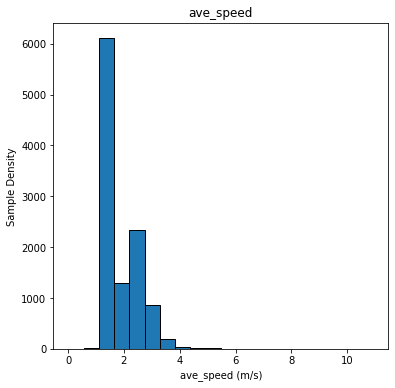

In [136]:
keep_gdf.ave_speed_15.hist(figsize = (6,6),bins=20, edgecolor='black', grid=False)
plt.title('ave_speed')
plt.xlabel('ave_speed (m/s)')
plt.ylabel('Sample Density')

Text(0, 0.5, 'Sample Density')

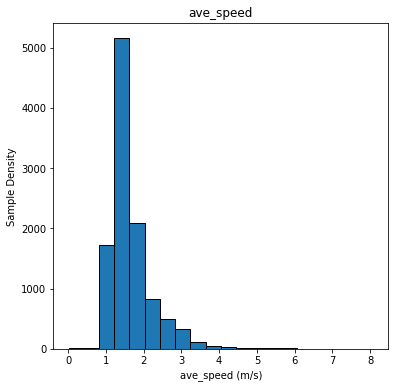

In [28]:
keep_gdf.ave_speed.hist(figsize = (6,6),bins=20, edgecolor='black', grid=False)
plt.title('ave_speed')
plt.xlabel('ave_speed (m/s)')
plt.ylabel('Sample Density')

In [29]:
## 实时朝向与转角
# angle
a_df = pd.DataFrame(data = None, columns = ['angle','angle_turn'])
# a_df['angle_list'] = a_df['angle_list'].astype(object)
for j in tqdm(keep_gdf.index):
    a_float = []
    b_float = []
    k = 0
    for i in keep_gdf['paths'][j]:
        if k == 0:
            a_float.append(0)
            l1 = i
            seg = np.array(l1)
            seg = seg[1] - seg[0]
            angle_l1 = np.angle(complex(*(seg)), deg=True)
            b_float.append(angle_l1)
            k = k + 1
        else:
            l2 = i
            seg = np.array(l1)
            seg = seg[1] - seg[0]
            angle_l1 = np.angle(complex(*(seg)), deg=True)
            
            seg = np.array(l2)
            seg = seg[1] - seg[0]
            angle_l2 = np.angle(complex(*(seg)), deg=True)
            
            a_float.append(angle_l2-angle_l1)
            l1 = i
            b_float.append(angle_l2)
    a_df.loc[j,'angle_turn'] = a_float
    a_df.loc[j,'angle'] = b_float
keep_gdf['angle'] = a_df['angle']
keep_gdf['angle_turn'] = a_df['angle_turn']

100%|███████████████████████████████████████| 10907/10907 [03:04<00:00, 58.96it/s]


In [30]:
b = []
for i in tqdm(keep_gdf.index):
    a = []
    for j in keep_gdf['angle_turn'][i]:
        if j > 180:
            a.append(j-360)
        elif j <= -180:
            a.append(j+360)
        else:
            a.append(j)
    b.append(a)

keep_gdf['angle_turn'] = b

100%|█████████████████████████████████████| 10907/10907 [00:01<00:00, 7080.01it/s]


In [31]:
keep_gdf['start_hour'] = keep_gdf.start_datetime.apply(lambda x: x.hour)
keep_gdf['start_date'] = keep_gdf.start_datetime.apply(lambda x: x.date())

In [32]:
# 标准化
def scale(series, x):
    mean = np.mean(series)
    std = np.std(series)
    return (x-mean)/std

In [33]:
# 归一化
def normal(series, x):
    mean = np.mean(series)
    std = np.std(series)
    smax = np.max(series)
    smin = np.min(series)
    
    return (x-smin)/(smax-smin)

In [34]:
keep_gdf.columns

Index(['trid', 'sjointype', 'start_g', 'end_g', 'start_datetime',
       'end_datetime', 'geometry', 'start_latitude', 'start_longitude',
       'end_latitude', 'end_longitude', 'pathlength', 'duration',
       'duration_minutes', 'points', 'points4326', 'paths',
       'path_count_every_time', 'speed', 'speed_15', 'ave_speed',
       'ave_speed_15', 'angle', 'angle_turn', 'start_hour', 'start_date'],
      dtype='object')

In [35]:
# 总回转 Sa

In [36]:
keep_gdf['angle_turn']

1        [0, 14.850563180835564, 5.349754218118875, -6....
3        [0, 1.5668585072389902, 2.9028516290932913, -2...
4        [0, -15.023436872903702, -15.153863233315391, ...
5        [0, -9.671638539597538, 8.183315338137533, -8....
7        [0, 19.177869370973212, -17.10454848646676, -8...
                               ...                        
17149    [0, 21.581830191182327, 37.97525685320247, 35....
17150    [0, 115.83142070647983, 0.9091642574702625, 92...
17151    [0, 10.352028602562115, 0.44100318902385993, -...
17153    [0, -4.760350139051027, 36.1364904995813, 39.3...
17154    [0, 45.51515433446478, 55.516132823104684, 8.9...
Name: angle_turn, Length: 10907, dtype: object

In [37]:
# sum the angle_turn to calculate the circles
keep_gdf['angle_turn_sum'] = keep_gdf['angle_turn'].apply(lambda x: sum(x))
for i in tqdm(keep_gdf.index):
    a = keep_gdf.loc[i,'angle_turn_sum']
    if a > 0 :
        keep_gdf.loc[i,'turn_sum'] = a/360
    if a <= 0 :
        keep_gdf.loc[i,'turn_sum'] = -a/360


100%|█████████████████████████████████████| 10907/10907 [00:02<00:00, 3912.04it/s]


<AxesSubplot:xlabel='turn_sum', ylabel='Density'>

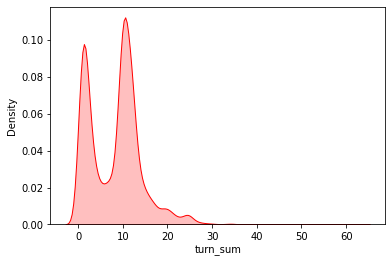

In [38]:
x = keep_gdf['turn_sum']
sns.kdeplot(x, shade=True, color="r")

In [39]:
keep_gdf.columns

Index(['trid', 'sjointype', 'start_g', 'end_g', 'start_datetime',
       'end_datetime', 'geometry', 'start_latitude', 'start_longitude',
       'end_latitude', 'end_longitude', 'pathlength', 'duration',
       'duration_minutes', 'points', 'points4326', 'paths',
       'path_count_every_time', 'speed', 'speed_15', 'ave_speed',
       'ave_speed_15', 'angle', 'angle_turn', 'start_hour', 'start_date',
       'angle_turn_sum', 'turn_sum'],
      dtype='object')

In [40]:
keep_gdf[['start_hour','ave_speed_15','pathlength','duration_minutes']].describe()

,start_hour,ave_speed_15,pathlength,duration_minutes
count,10907.000000,10907.000000,10907.000000,10907.000000
mean,18.242138,1.868022,6068.600495,65.609609
std,5.462503,0.656342,1803.881445,207.036970
min,0.000000,0.017353,59.554075,14.000000
25%,18.000000,1.370059,5053.643453,57.000000
50%,21.000000,1.568021,5254.749871,59.000000
75%,22.000000,2.378415,6210.151834,71.000000
max,23.000000,10.923666,26864.291147,21632.000000


In [41]:
# 回转半径 Rg

In [42]:
# 求质心
def masspoint(ptlst):
    a = []
    b = []
    for i in ptlst:
        a.append(i[0])
        b.append(i[1])
    return (np.mean(a),np.mean(b))

keep_gdf['masspt'] = keep_gdf['points4326'].apply(lambda x : Point(masspoint(x)[0],masspoint(x)[1]))

In [43]:
# 求每条路径的回转半径
def Rg(ptlst):
    a = []
    masspt = masspoint(ptlst)
    for i in ptlst:
        a.append((i[0]-masspt[0])**2+(i[1]-masspt[1])**2)
    return np.mean(a)**0.5
keep_gdf['Rg'] = keep_gdf['points'].apply(lambda x : Rg(x))

<AxesSubplot:xlabel='Rg', ylabel='Density'>

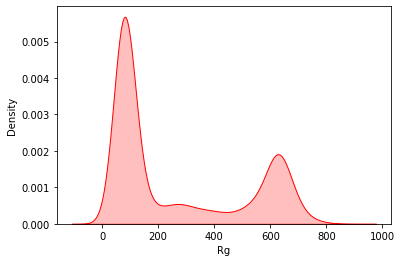

In [44]:
x = keep_gdf['Rg']
sns.kdeplot(x, shade=True, color="r")

# classification

In [45]:
# OD 判别区域导入（made by QGIS）
residence_gdf = gpd.read_file('../../202204_keepdata/03_data/campus/area.shp')
residence_gdf.to_crs('epsg:4326',inplace = True)
residence_gdf.drop(columns = 'id',inplace = True)
residence_gdf.columns = ['type','geometry']
residence_gdf

,type,geometry
0,middle_area,"POLYGON ((116.32450 39.99960, 116.32203 39.999..."
1,northwest_area,"POLYGON ((116.31302 40.00821, 116.31301 40.008..."
2,west_area,"POLYGON ((116.31122 40.00330, 116.30932 40.003..."
3,sourthwest_area,"MULTIPOLYGON (((116.31556 39.99964, 116.31559 ..."
4,east_area,"POLYGON ((116.32940 40.00793, 116.32960 40.007..."
5,north_area,"POLYGON ((116.32204 40.01195, 116.32276 40.011..."


(116.31151096847508, 116.32900483092568, 39.99790733424753, 40.01026874824965)

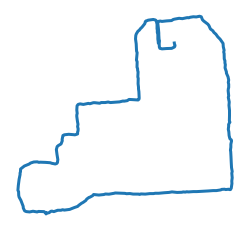

In [46]:
keep_gdf[3:4].plot(linewidth = 3)
plt.axis('off')

(116.30822722, 116.33189218, 39.990303725, 40.01297637500001)

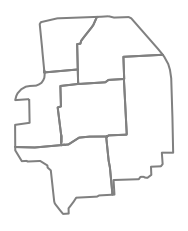

In [47]:
ax = residence_gdf.plot(edgecolor = 'gray', linewidth = 2,facecolor = 'none')
# residence_gdf[residence_gdf['type'] == 'north_area'].plot(ax=ax, edgecolor = 'red', linewidth = 2,facecolor = 'none')
# keep_gdf[3:4].plot(ax=ax,linewidth = 3)
plt.axis('off')

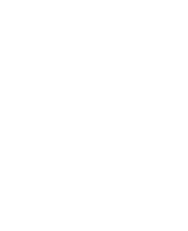

In [48]:
ax = residence_gdf.plot(edgecolor = 'white', linewidth = 2,facecolor = 'none',alpha = 0.1)
residence_gdf[residence_gdf['type'] == 'north_area'].plot(ax=ax, edgecolor = 'white', linewidth = 2,facecolor = 'none',alpha = 0.7)
# keep_gdf[3:4].plot(ax=ax,linewidth = 3)
plt.axis('off')
plt.savefig('../04_output/2.png')

In [49]:
#判别起始点所在的类型
a = []
for i in tqdm(keep_gdf.index):
    pt = Point(keep_gdf.loc[i,'points4326'][0])
    gdf_test = gpd.GeoDataFrame({'geometry':[pt]})
    gdf_test_copy = gdf_test.sjoin(residence_gdf,op = 'within')
    if len(gdf_test_copy) > 0:
        a.append(gdf_test_copy['type'].to_list()[0])
    else:
        a.append('0')

100%|███████████████████████████████████████| 10907/10907 [02:08<00:00, 84.97it/s]


In [50]:
keep_gdf['ODcluster_0'] = a

In [51]:
keep_gdf.ODcluster_0.value_counts()

north_area         5123
east_area          1960
middle_area        1883
sourthwest_area    1216
northwest_area      376
west_area           349
Name: ODcluster_0, dtype: int64

In [52]:
# Trajectories Classification

In [53]:
keep_gdf[['Rg','turn_sum']].describe()

,Rg,turn_sum
count,10907.000000,1.090700e+04
mean,266.817746,8.332658e+00
std,239.202050,5.996168e+00
min,3.845988,7.894919e-17
25%,78.703260,2.246655e+00
50%,99.891087,9.661555e+00
75%,550.684782,1.164873e+01
max,866.029515,6.252942e+01


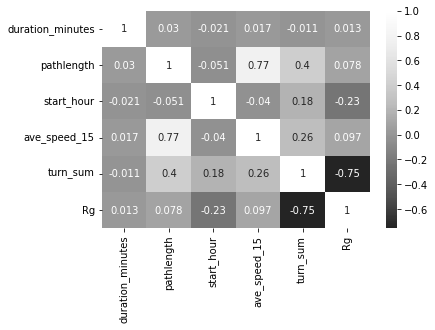

In [54]:
import matplotlib.pyplot as mp

df_corr = keep_gdf[['duration_minutes','pathlength','start_hour','ave_speed_15','turn_sum','Rg']].corr()

# 可视化
sns.heatmap(df_corr, center=0, annot=True, cmap='Greys_r')
mp.show()

In [55]:
keep_gdf['duration_minutes_15'] = keep_gdf.pathlength / keep_gdf.ave_speed_15

In [56]:
x3 = keep_gdf['duration_minutes_15']
x4 = keep_gdf.pathlength
x5 = keep_gdf.ave_speed_15

<AxesSubplot:xlabel='Rg', ylabel='Density'>

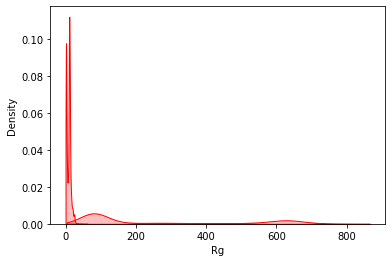

In [57]:
# Rg classification
x1 = keep_gdf['Rg']
sns.kdeplot(x1, shade=True, color="r", cut = 0)

x2 = keep_gdf['turn_sum']
sns.kdeplot(x2, shade=True, color="r",cut = 0)

In [58]:
import numpy as np
from sklearn import preprocessing
X = np.array(list(zip(x1,x2)))
t = preprocessing.MinMaxScaler().fit(X)
X = t.transform(X)

In [59]:
# KMeans

In [60]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [61]:

# 标准化
# t= preprocessing.MinMaxScaler().fit(X)
# X=t.transform(X)

# from sklearn.mixture import GaussianMixture as GM
# gm = GM(n_components=3,random_state=0).fit(X)
# Rggmlst = gm.predict(X)

from sklearn.cluster import KMeans
km = KMeans(n_clusters=3,random_state=0).fit(X)
Rggmlst = km.predict(X)

df = pd.DataFrame(data = {'cluster':km.predict(X),'Rg':keep_gdf['Rg'].tolist(),'turn_sum':keep_gdf['turn_sum'].tolist()})
df.groupby('cluster').describe()

Rg                                                             \
          count        mean        std         min         25%         50%   
cluster                                                                      
0        6523.0   87.115341  25.761640    3.845988   73.983866   80.452674   
1        3126.0  619.388330  55.798217  467.370996  594.431383  625.387784   
2        1258.0  322.511814  73.700967  170.355103  262.353241  311.444843   

                                turn_sum                                     \
                75%         max    count       mean       std           min   
cluster                                                                       
0         85.409508  270.540881   6523.0  12.023900  4.488029  5.743345e-08   
1        648.669795  866.029515   3126.0   2.047237  1.985247  7.894919e-17   
2        379.974277  496.378032   1258.0   4.811398  4.034102  4.726444e-04   

                                                    
              25%        50%        75%        max  
cluster                                             
0        9.914551  11.045292  12.730192  62.529419  
1        0.938320   1.480527   2.415171  23.614488  
2        1.753912   3.652455   7.142062  28.503042

In [62]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
silhouette_score(X,km.labels_)

0.7131506867121113

In [63]:
for i in range(2,9,1):
    # 实例化，训练，并查看结果分布
    n_clusters = i
    clusterer = KMeans(n_clusters=n_clusters,random_state=0)
    clusterer = clusterer.fit(X)
    pd.value_counts(clusterer.labels_)
    # 计算非长尾数据的轮廓系数均值
    cluster_labels = clusterer.labels_
    print(np.average(silhouette_samples(X, cluster_labels)[cluster_labels != 0]))
    print(silhouette_score(X,cluster_labels))
    # 输出结果


0.7583623153627229
0.778156217633225
0.6688672094900546
0.7131506867121113
0.6302348788319748
0.6596073273689049
0.6372127636142111
0.6176177218561542
0.4719994859890967
0.5656380944208089
0.5117111931721374
0.5289969589917788
0.5491778363875018
0.5229018403928946


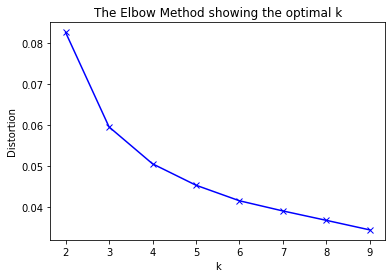

In [64]:
# # clustering dataset
# # determine k using elbow method
 
# from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
# import numpy as np
# import matplotlib.pyplot as plt
 
# x1 = np.array([3, 1, 1, 2, 1, 6, 6, 6, 5, 6, 7, 8, 9, 8, 9, 9, 8])
# x2 = np.array([5, 4, 5, 6, 5, 8, 6, 7, 6, 7, 1, 2, 1, 2, 3, 2, 3])
 
# plt.plot()
# plt.xlim([0, 10])
# plt.ylim([0, 10])
# plt.title('Dataset')
# plt.scatter(x1, x2)
# plt.show()
 
# # create new plot and data
# plt.plot()
# X = np.array(list(zip(x1, x2))).reshape(len(x1), 2)
# colors = ['b', 'g', 'r']
# markers = ['o', 'v', 's']
 
# k means determine k
distortions = []
K = range(2, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [65]:
lst = []
for i in range(len(Rggmlst)):
    if Rggmlst[i] == 0: # 小范围
        lst.append(0)
    if Rggmlst[i] == 1: # 大范围
        lst.append(0)
    if Rggmlst[i] == 2: # 中范围
        lst.append(0)

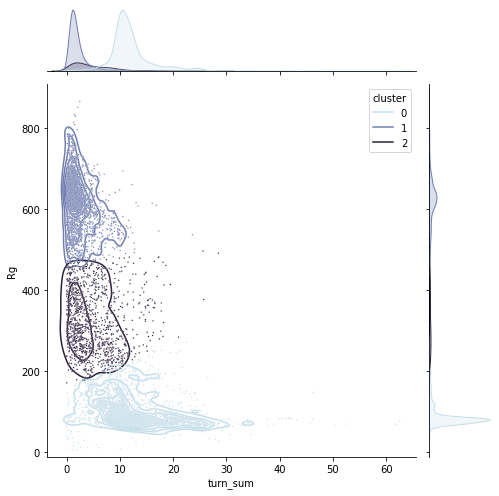

In [66]:
#联合分布
g = sns.jointplot(data=df,x='turn_sum',y='Rg',hue='cluster',alpha = 1,size = 7,
                  palette = "ch:s=.25,rot=-.25",
                  # marker="+",
                  s=2
                 )
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=9)
plt.savefig('../04_output/joinplt1.jpg')

In [67]:
from scipy import stats
u = df[df.cluster == 2].turn_sum.mean()
std = df[df.cluster == 2].turn_sum.std()
stats.kstest(df[df.cluster == 2].turn_sum,'norm',(u,std))

KstestResult(statistic=0.11928563412744458, pvalue=4.695566397119927e-16)

<AxesSubplot:>

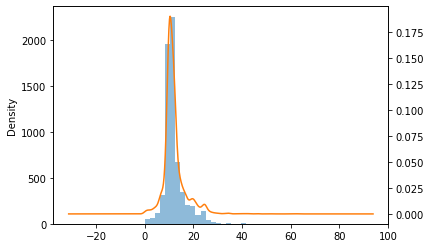

In [68]:
s = df[df.cluster == 0].turn_sum
ax1 = s.hist(bins = 30,alpha = 0.5)
s.plot(kind = 'kde',secondary_y = True,ax=ax1)

In [69]:
# add

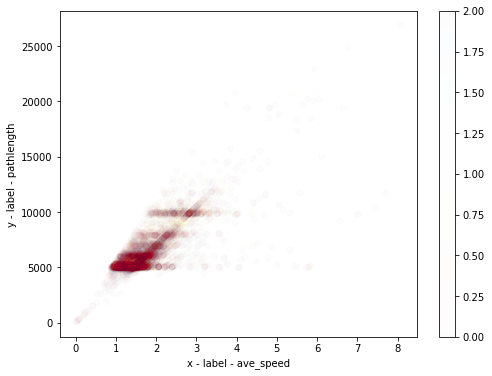

In [70]:
## data
xrange_list = keep_gdf['ave_speed'].tolist()
yrange_list = keep_gdf['pathlength'].tolist()

## 路段范围可视化
x = xrange_list
y = yrange_list

plt.figure(figsize = (8,6))

plt.scatter(x, y,alpha=0.01,c=Rggmlst, cmap='RdYlBu')
plt.xlabel("x - label - ave_speed")
plt.ylabel("y - label - pathlength")
# plt.legend()
plt.colorbar()

plt.show()

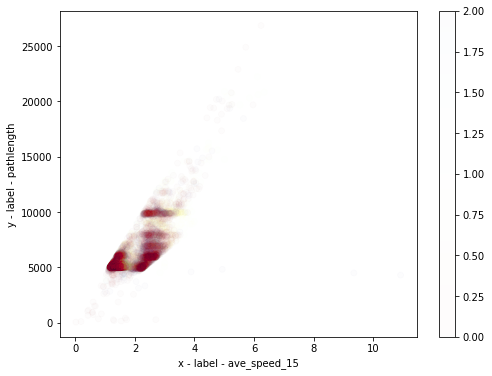

In [71]:
## data
xrange_list = keep_gdf['ave_speed_15'].tolist()
yrange_list = keep_gdf['pathlength'].tolist()

## 路段范围可视化
x = xrange_list
y = yrange_list

plt.figure(figsize = (8,6))

plt.scatter(x, y,alpha=0.01,c=Rggmlst, cmap='RdYlBu')
plt.xlabel("x - label - ave_speed_15")
plt.ylabel("y - label - pathlength")
# plt.legend()
plt.colorbar()

plt.show()

In [72]:
a = keep_gdf[keep_gdf['duration_minutes']>300]

<AxesSubplot:xlabel='ave_speed', ylabel='Density'>

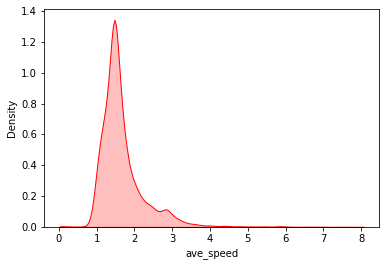

In [73]:
# length classification
x = keep_gdf['ave_speed'][~(keep_gdf['trid'].isin(a.trid))]
sns.kdeplot(x, shade=True, color="r",cut = 0)

<AxesSubplot:xlabel='ave_speed_15', ylabel='Density'>

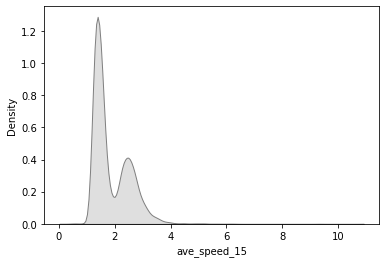

In [74]:
# length classification
x = keep_gdf['ave_speed_15'][~(keep_gdf.trid.isin(a.trid))]
sns.kdeplot(x, shade=True, color="gray",cut = 0)

<AxesSubplot:xlabel='start_hour', ylabel='Density'>

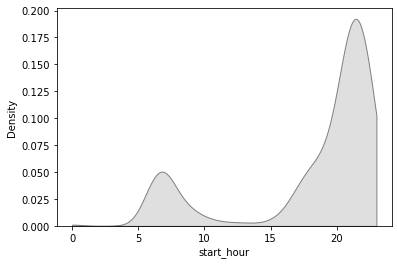

In [75]:

x = keep_gdf['start_hour'][~(keep_gdf.trid.isin(a.trid))]
sns.kdeplot(x, shade=True, color="gray",cut = 0)

<AxesSubplot:xlabel='duration_minutes', ylabel='Density'>

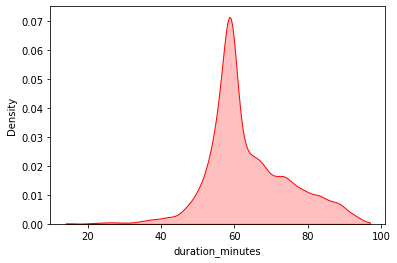

In [76]:
# length classification
x = keep_gdf['duration_minutes'][~(keep_gdf.trid.isin(a.trid))]
sns.kdeplot(x, shade=True, color="r",cut = 0)

In [77]:
keep_gdf

,trid,sjointype,start_g,end_g,start_datetime,end_datetime,geometry,start_latitude,start_longitude,end_latitude,...,angle,angle_turn,start_hour,start_date,angle_turn_sum,turn_sum,masspt,Rg,ODcluster_0,duration_minutes_15
1,1,within,1.659529e+09,1.659533e+09,2022-08-03 20:21:06,2022-08-03 21:24:05,"LINESTRING (116.32657 40.00550, 116.32617 40.0...",40.005496,116.326573,40.002287,...,"[-176.22295588141483, -161.37239270057927, -15...","[0, 14.850563180835564, 5.349754218118875, -6....",20,2022-08-03,5454.330624,15.150918,POINT (116.3249806523324 40.00432101978853),248.801437,east_area,3621.707664
3,3,within,1.659485e+09,1.659489e+09,2022-08-03 08:00:04,2022-08-03 09:18:02,"LINESTRING (116.32275 40.00926, 116.32276 40.0...",40.009263,116.322751,40.009053,...,"[-77.08374516755092, -75.51688666031193, -72.6...","[0, 1.5668585072389902, 2.9028516290932913, -2...",8,2022-08-03,3789.283221,10.525787,POINT (116.3233652111902 40.00874787223082),84.428779,north_area,3870.008197
4,4,within,1.659481e+09,1.659486e+09,2022-08-03 06:54:07,2022-08-03 08:15:03,"LINESTRING (116.32106 39.99614, 116.32103 39.9...",39.996137,116.321057,40.004077,...,"[126.03940298200904, 111.01596610910534, 95.86...","[0, -15.023436872903702, -15.153863233315391, ...",6,2022-08-03,3035.301426,8.431393,POINT (116.3168749073538 40.0026419180722),290.471055,sourthwest_area,4103.736271
5,5,within,1.659481e+09,1.659484e+09,2022-08-03 06:54:07,2022-08-03 07:42:04,"LINESTRING (116.32274 40.00812, 116.32272 40.0...",40.008123,116.322741,40.008271,...,"[111.01819073564592, 101.34655219604838, 109.5...","[0, -9.671638539597538, 8.183315338137533, -8....",6,2022-08-03,717.613888,1.993372,POINT (116.3212647595198 40.00383895851666),617.399293,north_area,4059.867979
7,7,within,1.659537e+09,1.659540e+09,2022-08-03 22:33:04,2022-08-03 23:24:03,"LINESTRING (116.31310 39.99862, 116.31320 39.9...",39.998622,116.313105,40.001092,...,"[11.191230870862979, 30.36910024183619, 13.264...","[0, 19.177869370973212, -17.10454848646676, -8...",22,2022-08-03,-11.191231,0.031087,POINT (116.321141241306 40.0050823073638),670.928003,west_area,4030.665384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17149,17149,within,1.656631e+09,1.656635e+09,2022-07-01 07:20:07,2022-07-01 08:18:04,"LINESTRING (116.31589 40.00306, 116.31621 40.0...",40.003056,116.315888,40.003406,...,"[4.229434235449296, 25.811264426631624, 63.786...","[0, 21.581830191182327, 37.97525685320247, 35....",7,2022-07-01,8923.594856,24.787763,POINT (116.3162245768625 40.00377744836503),64.544057,middle_area,4089.142512
17150,17150,within,1.656631e+09,1.656635e+09,2022-07-01 07:20:07,2022-07-01 08:18:04,"LINESTRING (116.31084 39.99946, 116.31082 39.9...",39.999456,116.310839,39.999116,...,"[-99.67420169896748, 16.15721900751236, 17.066...","[0, 115.83142070647983, 0.9091642574702625, 92...",7,2022-07-01,1515.013291,4.208370,POINT (116.3201247259424 40.00364481139272),672.401711,west_area,3066.819582
17151,17151,within,1.656627e+09,1.656631e+09,2022-07-01 06:16:04,2022-07-01 07:18:02,"LINESTRING (116.31535 40.00132, 116.31536 40.0...",40.001317,116.315349,40.003015,...,"[96.46558816090446, 106.81761676346657, 107.25...","[0, 10.352028602562115, 0.44100318902385993, -...",6,2022-07-01,4222.479585,11.729110,POINT (116.3161589415436 40.00370568395598),87.901908,middle_area,2249.028711
17153,17153,within,1.656675e+09,1.656680e+09,2022-07-01 19:36:04,2022-07-01 20:48:03,"LINESTRING (116.31581 40.00352, 116.31583 40.0...",40.003516,116.315808,40.003435,...,"[-66.3004047665743, -71.06075490562533, -34.92...","[0, -4.760350139051027, 36.1364904995813, 39.3...",19,2022-07-01,5581.979773,15.505499,POINT (116.3162073245593 40.00373738916839),67.778530,middle_area,2336.652923


<AxesSubplot:ylabel='Density'>

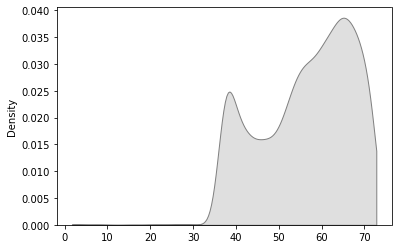

In [78]:

x = keep_gdf['pathlength'] / keep_gdf['ave_speed_15'] /60
sns.kdeplot(x, shade=True, color="gray",cut = 0)


<AxesSubplot:ylabel='Density'>

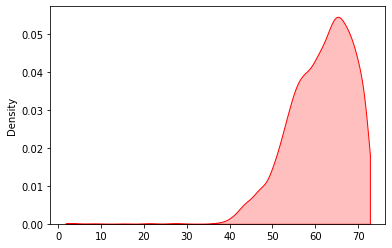

In [79]:

x = keep_gdf[keep_gdf['ave_speed_15']<2]['pathlength'] / keep_gdf[keep_gdf['ave_speed_15']<2]['ave_speed_15'] /60
sns.kdeplot(x, shade=True, color="r",cut = 0)


<AxesSubplot:ylabel='Density'>

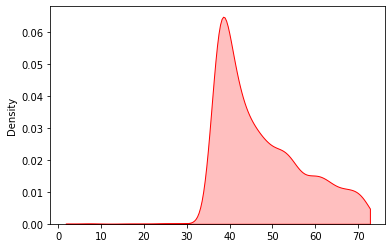

In [80]:

x = keep_gdf[keep_gdf['ave_speed_15']>=2]['pathlength'] / keep_gdf[keep_gdf['ave_speed_15']>=2]['ave_speed_15'] /60
sns.kdeplot(x, shade=True, color="r",cut = 0)


In [81]:
keep_gdf['duration_minutes'].describe()

count    10907.000000
mean        65.609609
std        207.036970
min         14.000000
25%         57.000000
50%         59.000000
75%         71.000000
max      21632.000000
Name: duration_minutes, dtype: float64

In [82]:
# 赋值给原表
keep_gdf['Rgcluster_gm'] = Rggmlst

In [83]:
keep_gdf['Rgcluster_gm'].value_counts()

0    6523
1    3126
2    1258
Name: Rgcluster_gm, dtype: int64

# classify result

In [84]:
# cluster 存储回原表
clusterlst = []
for i in tqdm(keep_gdf.index):
    clusterlst.append(keep_gdf.loc[i,'ODcluster_0'] + '_'+ str(keep_gdf.loc[i,'Rgcluster_gm']))
keep_gdf['cluster'] = clusterlst

100%|████████████████████████████████████| 10907/10907 [00:00<00:00, 53211.89it/s]


In [85]:
keep_gdf['ODcluster_0'].value_counts()


north_area         5123
east_area          1960
middle_area        1883
sourthwest_area    1216
northwest_area      376
west_area           349
Name: ODcluster_0, dtype: int64

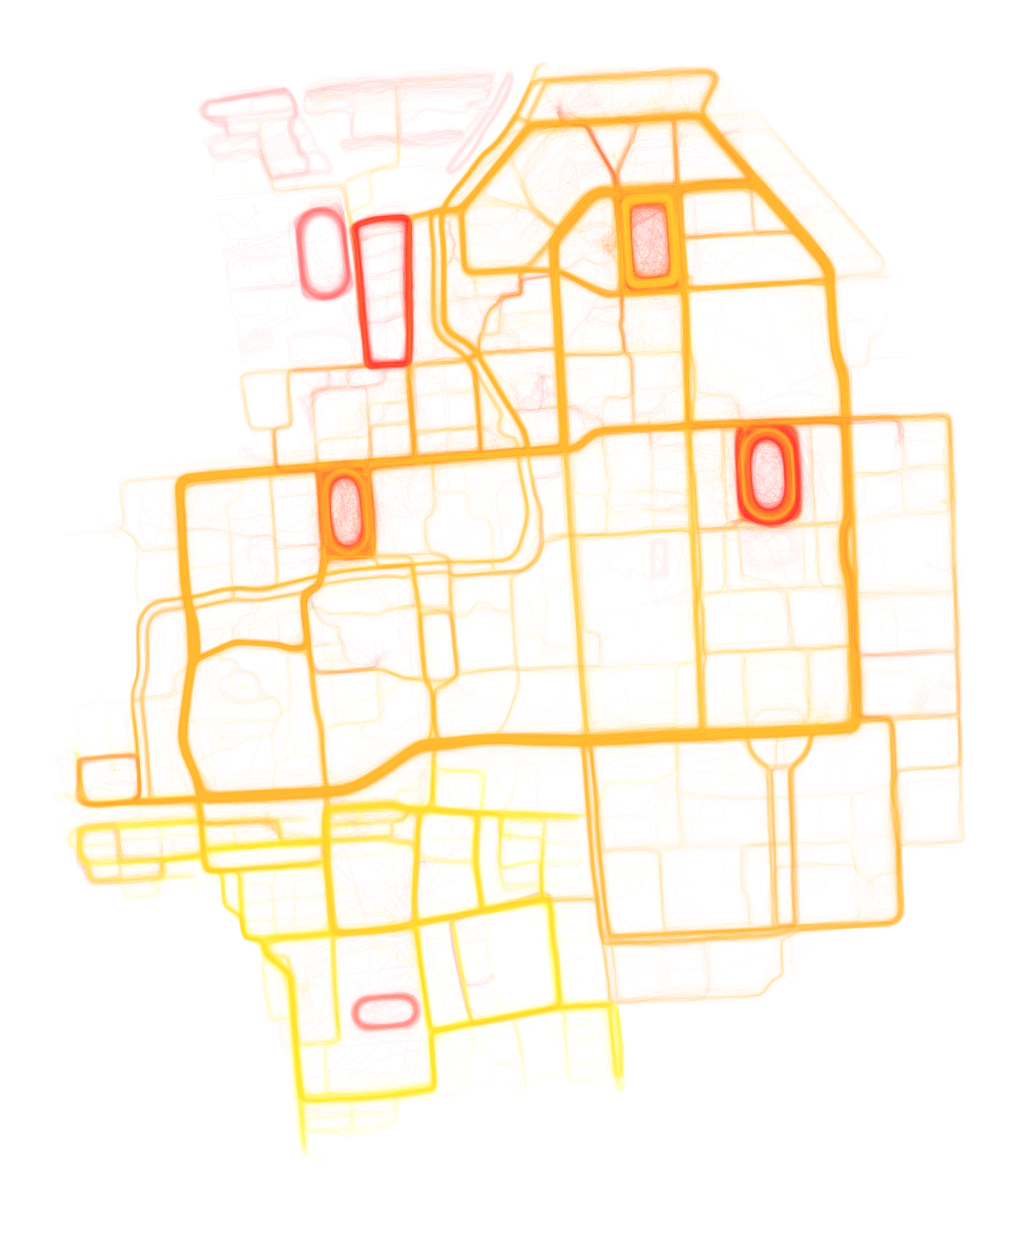

In [86]:
# 创建一个画布，尺寸为8x6，在此画布上进行绘图
plt.figure(figsize=(18,25))
x=1 #行
y=1 #列
ODcluster_lst = ['north_area','middle_area','sourthwest_area','northwest_area','west_area','east_area']
for i in range(len(ODcluster_lst)):
    ODcluster_0 = ODcluster_lst[i]

    ax1 = plt.subplot(x,y,1)
    # thu_gdf.plot(ax=ax1,color = 'black')
    keep_gdf[keep_gdf['ODcluster_0']== ODcluster_0][keep_gdf['Rgcluster_gm'] == 0].plot(color = 'r',ax = ax1,alpha = 0.02)
    plt.axis('off')

    ax1 = plt.subplot(x,y,1)
    # thu_gdf.plot(ax=ax1,color = 'black')
    keep_gdf[keep_gdf['ODcluster_0']== ODcluster_0][keep_gdf['Rgcluster_gm'] == 1].plot(color = 'orange',ax = ax1,alpha = 0.02)
    plt.axis('off')

    ax1 = plt.subplot(x,y,1)
    # thu_gdf.plot(ax=ax1,color = 'black')
    keep_gdf[keep_gdf['ODcluster_0']== ODcluster_0][keep_gdf['Rgcluster_gm'] == 2].plot(color = 'yellow',ax = ax1,alpha = 0.02)
    plt.axis('off')
plt.savefig('../04_output/1.png')

<Figure size 360x360 with 0 Axes>

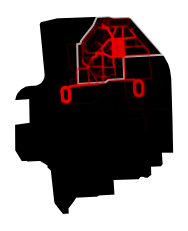

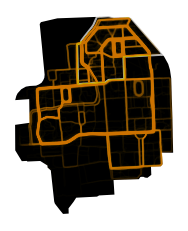

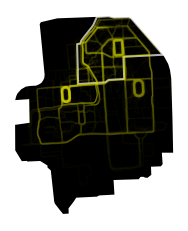

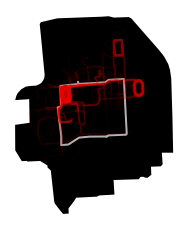

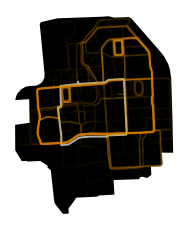

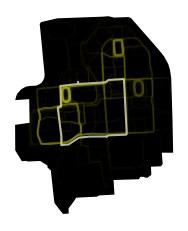

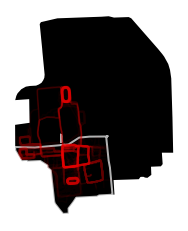

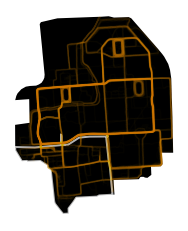

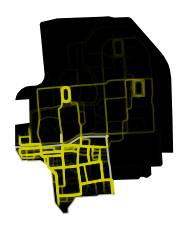

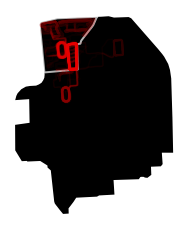

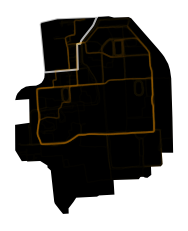

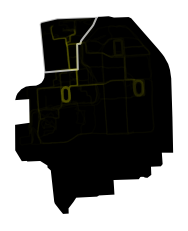

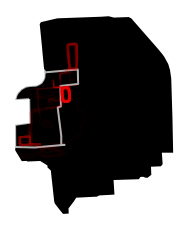

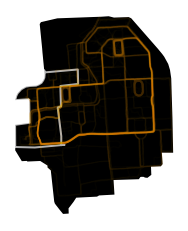

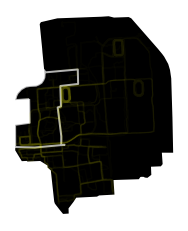

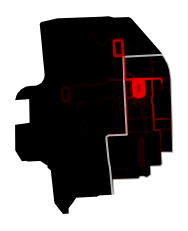

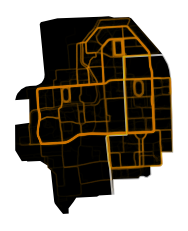

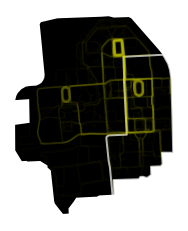

In [87]:
# 创建一个画布，尺寸为8x6，在此画布上进行绘图
plt.figure(figsize=(5,5))
ODcluster_lst = ['north_area','middle_area','sourthwest_area','northwest_area','west_area','east_area']
for i in range(len(ODcluster_lst)):
    ODcluster_0 = ODcluster_lst[i]

    ax1 = thu_gdf.plot(facecolor = 'black')
    keep_gdf[keep_gdf['ODcluster_0']== ODcluster_0][keep_gdf['Rgcluster_gm'] == 0].plot(color = 'r',ax = ax1,alpha = 0.04)
    # residence_gdf.plot(ax = ax1,edgecolor = 'white', linewidth = 1,facecolor = 'none',alpha = 0.1)
    residence_gdf[residence_gdf['type'] == ODcluster_0].plot(ax = ax1, edgecolor = 'white', linewidth = 2,facecolor = 'none',alpha = 0.7)
    plt.axis('off')
    plt.savefig('../04_output/1001_/'+str(3*i+1)+'.png')
    
    ax1 = thu_gdf.plot(facecolor = 'black')
    keep_gdf[keep_gdf['ODcluster_0']== ODcluster_0][keep_gdf['Rgcluster_gm'] == 1].plot(color = 'orange',ax = ax1,alpha = 0.02)
    # residence_gdf.plot(ax = ax1,edgecolor = 'white', linewidth = 1,facecolor = 'none',alpha = 0.1)
    residence_gdf[residence_gdf['type'] == ODcluster_0].plot(ax = ax1, edgecolor = 'white', linewidth = 2,facecolor = 'none',alpha = 0.7)
    plt.axis('off')
    plt.savefig('../04_output/1001_/'+str(3*i+2)+'.png')

    ax1 = thu_gdf.plot(facecolor = 'black')
    keep_gdf[keep_gdf['ODcluster_0']== ODcluster_0][keep_gdf['Rgcluster_gm'] == 2].plot(color = 'yellow',ax = ax1,alpha = 0.02)
    # residence_gdf.plot(ax = ax1,edgecolor = 'white', linewidth = 1,facecolor = 'none',alpha = 0.1)
    residence_gdf[residence_gdf['type'] == ODcluster_0].plot(ax = ax1, edgecolor = 'white', linewidth = 2,facecolor = 'none',alpha = 0.7)
    plt.axis('off')
    plt.savefig('../04_output/1001_/'+str(3*i+3)+'.png')


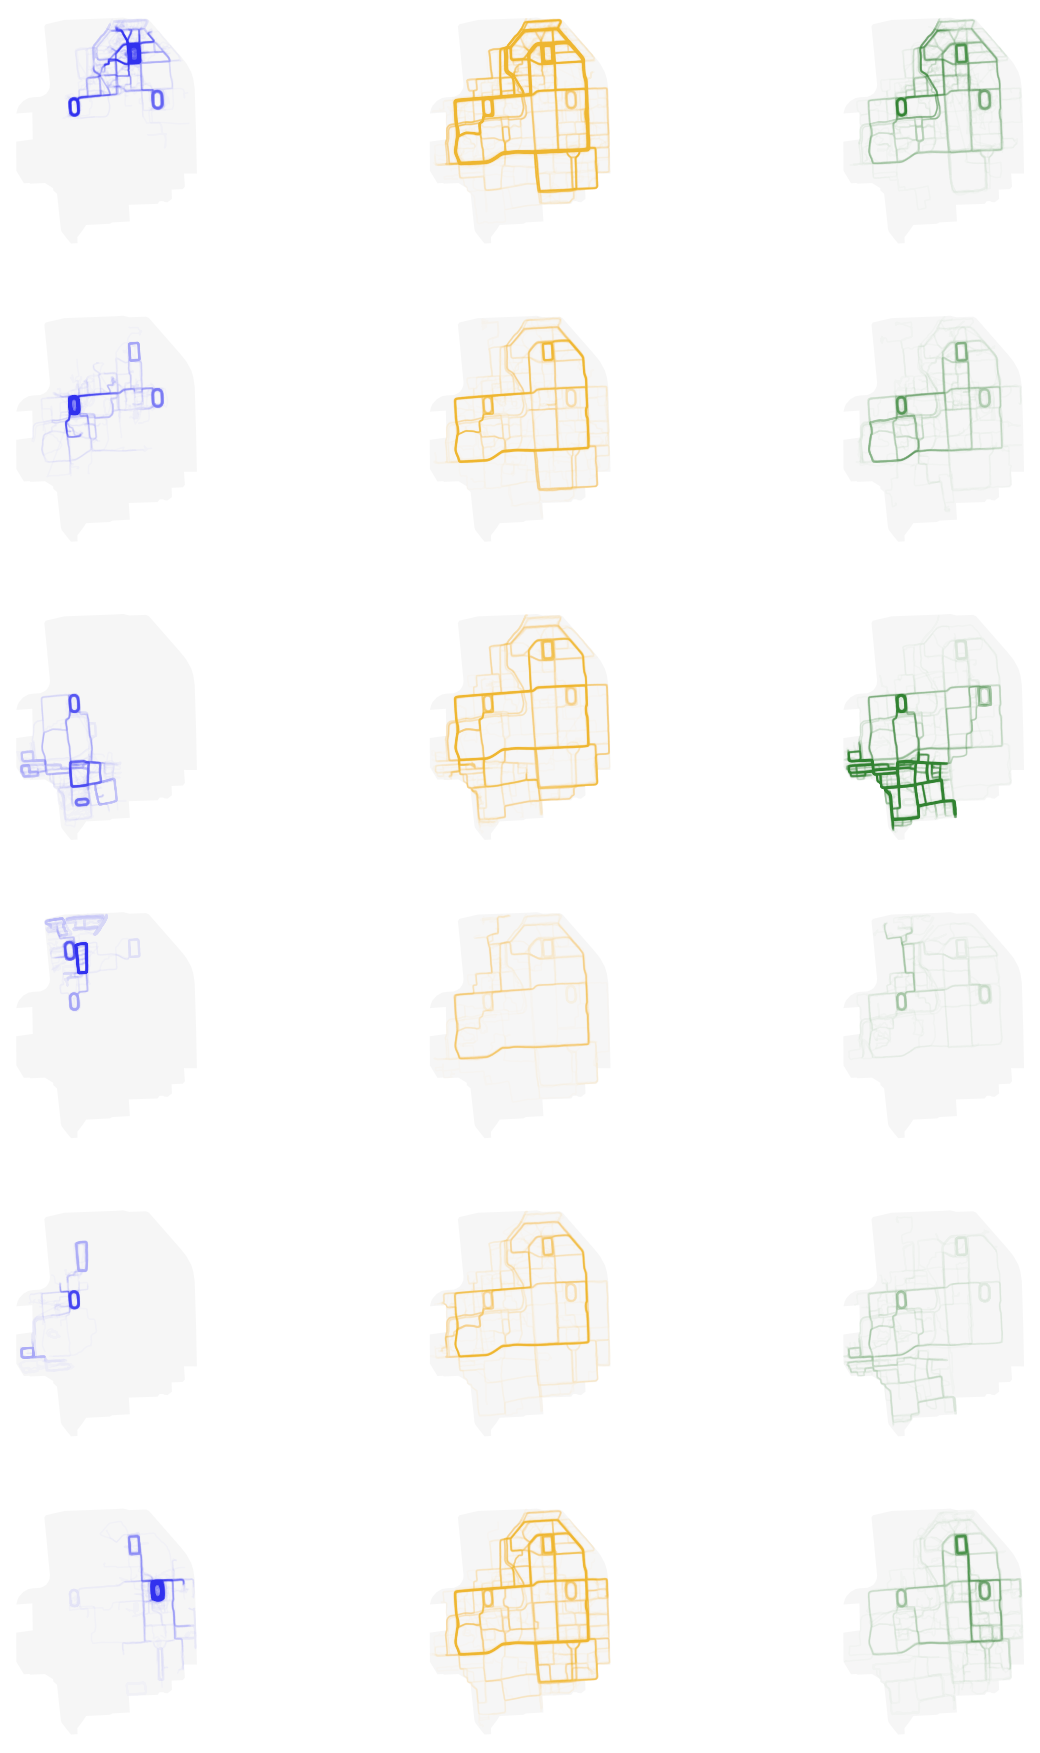

In [88]:
# 创建一个画布，尺寸为8x6，在此画布上进行绘图
plt.figure(figsize=(21,32))
x=6 #行
y=3 #列
ODcluster_lst = ['north_area','middle_area','sourthwest_area','northwest_area','west_area','east_area']
for i in range(len(ODcluster_lst)):
    ODcluster_0 = ODcluster_lst[i]

    ax1 = plt.subplot(x,y,3*i+1)
    thu_gdf.plot(ax=ax1,facecolor = 'lightgray',alpha = 0.2)
    keep_gdf[keep_gdf['ODcluster_0']== ODcluster_0][keep_gdf['Rgcluster_gm'] == 0].plot(color = 'blue',ax = ax1,alpha = 0.02)
    plt.axis('off')

    ax1 = plt.subplot(x,y,3*i+2)
    thu_gdf.plot(ax=ax1,facecolor = 'lightgray',alpha = 0.2)
    keep_gdf[keep_gdf['ODcluster_0']== ODcluster_0][keep_gdf['Rgcluster_gm'] == 1].plot(color = 'orange',ax = ax1,alpha = 0.02)
    plt.axis('off')

    ax1 = plt.subplot(x,y,3*i+3)
    thu_gdf.plot(ax=ax1,facecolor = 'lightgray',alpha = 0.2)
    keep_gdf[keep_gdf['ODcluster_0']== ODcluster_0][keep_gdf['Rgcluster_gm'] == 2].plot(color = 'darkgreen',ax = ax1,alpha = 0.02)
    plt.axis('off')


# 数量viz

In [89]:
CLUSTERS = []
for i in ODcluster_lst:
    CLUSTERS.append(i+'_0')
    CLUSTERS.append(i+'_1')
    CLUSTERS.append(i+'_2')

In [90]:
# 数量viz
def plot_cluster(cluster, data, annotate, ax, attribute):

    for cluster_inner in CLUSTERS:
        d = data[data["cluster"] == cluster_inner] 
        x = d["start_week"].values
        y = d[attribute].values

        if cluster_inner == cluster:
            ax.plot(x, y, color="#0b53c1", lw=2.4, zorder=10)# 实线
            ax.scatter(x, y, fc="w", ec="#0b53c1", s=60, lw=2.4, zorder=12) # 打点

        else:
            ax.plot(x, y, color="#BFBFBF", lw=1.5)# 灰线

    ax.set_yticks([])
    # Set location of horizontal ticks
    ax.set_xticks([0,3,9,18])

    # Set labels for horizontal ticks
    ax.set_xticklabels(
        ["w0", "w3", "w9", "w18"], 
        fontsize=16,
    )
    ax.tick_params(bottom=False)
    ax.set_frame_on(False)

    ax.set_title(cluster +'_'+ attribute, fontsize=14, fontweight=500)
    
    return ax

In [91]:
# 加入开始周字段
keep_gdf['start_week'] = keep_gdf['start_datetime'].apply(lambda x:int(int(str(x.date()-datetime.date(2022, 4, 16)).split(' days,')[0]) / 7))

In [92]:
keep_gdf[keep_gdf['start_week']==2].start_date.unique()

array([datetime.date(2022, 5, 6), datetime.date(2022, 5, 5)], dtype=object)

In [93]:
keep_gdf[keep_gdf['start_week']==1].start_date.unique()

array([datetime.date(2022, 4, 23), datetime.date(2022, 4, 24),
       datetime.date(2022, 4, 25), datetime.date(2022, 4, 27),
       datetime.date(2022, 4, 26), datetime.date(2022, 4, 29),
       datetime.date(2022, 4, 28)], dtype=object)

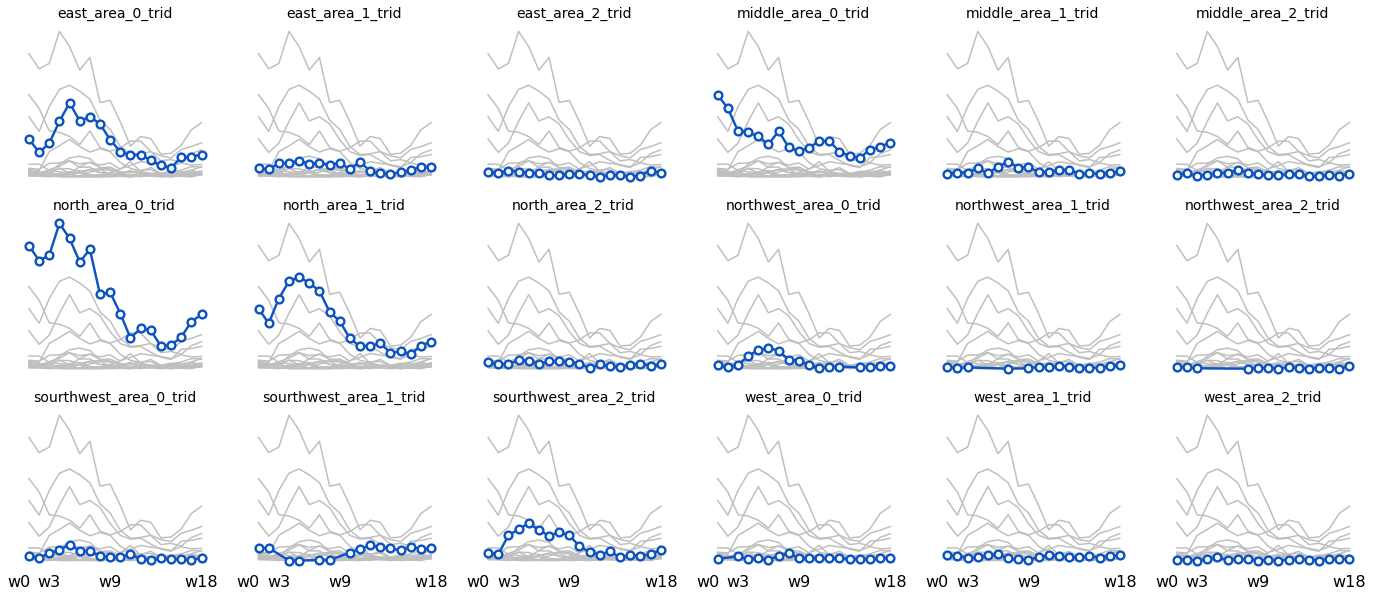

In [94]:
df = keep_gdf.groupby(['cluster','start_week']).count()['trid'].reset_index()

# 插值
for i in df[df['start_week'] == 2].index:
    a = df[df['cluster'] == df.loc[i,'cluster']][df['start_week'] == 1]['trid']
    b = df.loc[i,'trid']
    df.loc[i,'trid'] = int((a/7)*3 + (b/2)*4)
    
# # normalize
# df['trid_n'] = df['trid'].apply(lambda x : (np.e**x-1)/(np.e**x))

# viz!
# 输入数据集，按周和cluster聚类

CLUSTERS = df['cluster'].unique()
data = df
annotate = None
attribute = 'trid'
fig, axes = plt.subplots(3,6, sharex=True, sharey=True, figsize=(24, 10))
for idx, (ax, cluster) in enumerate(zip(axes.ravel(), CLUSTERS)):
    plot_cluster(cluster, data, annotate, ax, attribute)

# Since sharey=True, all vertical axis are inverted when we invert it in one subplot.
# ax.invert_yaxis()

In [95]:
# Time Series Plot with Rolling Average

Text(0, 0.5, 'Number of runners')

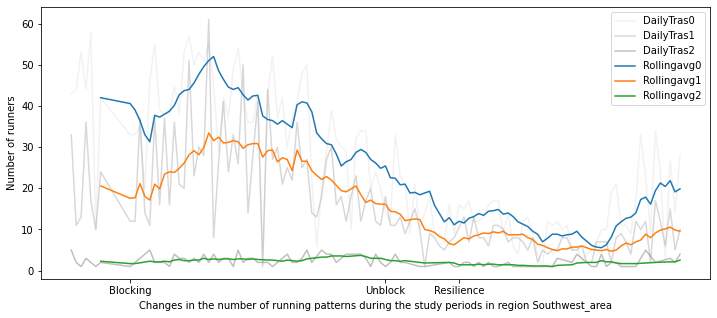

In [96]:
df = keep_gdf.groupby(['cluster','start_date']).count()['trid'].reset_index()
data0 = df[df['cluster'] == 'north_area_0']
data1 = df[df['cluster'] == 'north_area_1']
data2 = df[df['cluster'] == 'north_area_2']
# data0 = df[df['cluster'] == 'sourthwest_area_0']
# data1 = df[df['cluster'] == 'sourthwest_area_1']
# data2 = df[df['cluster'] == 'sourthwest_area_2']

df.cluster.unique()




# computing a 7 day rolling average
data0[ '7day_rolling_avg' ] = data0.trid.rolling( 7).mean()
data1[ '7day_rolling_avg' ] = data1.trid.rolling( 7).mean()
data2[ '7day_rolling_avg' ] = data2.trid.rolling( 7).mean()

# set figure size
plt.figure( figsize = ( 12, 5))

# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot( x = 'start_date',
			y = 'trid',
			data = data0,
			label = 'DailyTras0',
            alpha = 0.1,
            color= 'gray')

sns.lineplot( x = 'start_date',
			y = 'trid',
			data = data1,
			label = 'DailyTras1',
            alpha = 0.3,
            color= 'gray')

sns.lineplot( x = 'start_date',
			y = 'trid',
			data = data2,
			label = 'DailyTras2',
            alpha = 0.5,
            color= 'gray')

# plot using rolling average
sns.lineplot( x = 'start_date',
			y = '7day_rolling_avg',
			data = data0,
			label = 'Rollingavg0')

sns.lineplot( x = 'start_date',
			y = '7day_rolling_avg',
			data = data1,
			label = 'Rollingavg1')

sns.lineplot( x = 'start_date',
			y = '7day_rolling_avg',
			data = data2,
			label = 'Rollingavg2')


plt.xlabel('Changes in the number of running patterns during the study periods in region Southwest_area')

# setting customized ticklabels for x axis
pos = ['2022-05-05','2022-06-26','2022-07-11']

lab = ['Blocking','Unblock','Resilience']

plt.xticks( pos, lab)

plt.ylabel('Number of runners')

Text(0, 0.5, 'Number of runners')

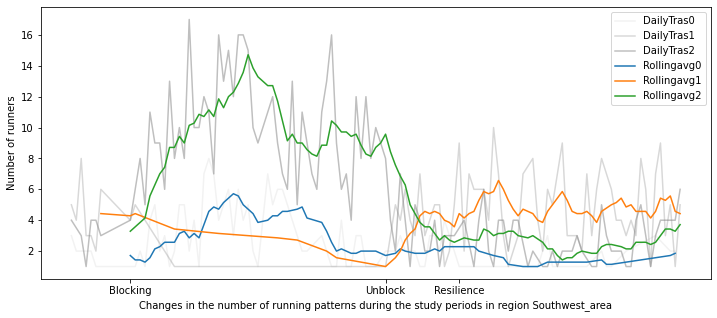

In [97]:
# data0 = df[df['cluster'] == 'north_area_0']
# data1 = df[df['cluster'] == 'north_area_1']
# data2 = df[df['cluster'] == 'north_area_2']
data0 = df[df['cluster'] == 'sourthwest_area_0']
data1 = df[df['cluster'] == 'sourthwest_area_1']
data2 = df[df['cluster'] == 'sourthwest_area_2']

df.cluster.unique()




# computing a 7 day rolling average
data0[ '7day_rolling_avg' ] = data0.trid.rolling( 7).mean()
data1[ '7day_rolling_avg' ] = data1.trid.rolling( 7).mean()
data2[ '7day_rolling_avg' ] = data2.trid.rolling( 7).mean()

# set figure size
plt.figure( figsize = ( 12, 5))

# plot a simple time series plot
# using seaborn.lineplot()
sns.lineplot( x = 'start_date',
			y = 'trid',
			data = data0,
			label = 'DailyTras0',
            alpha = 0.1,
            color= 'gray')

sns.lineplot( x = 'start_date',
			y = 'trid',
			data = data1,
			label = 'DailyTras1',
            alpha = 0.3,
            color= 'gray')

sns.lineplot( x = 'start_date',
			y = 'trid',
			data = data2,
			label = 'DailyTras2',
            alpha = 0.5,
            color= 'gray')

# plot using rolling average
sns.lineplot( x = 'start_date',
			y = '7day_rolling_avg',
			data = data0,
			label = 'Rollingavg0')

sns.lineplot( x = 'start_date',
			y = '7day_rolling_avg',
			data = data1,
			label = 'Rollingavg1')

sns.lineplot( x = 'start_date',
			y = '7day_rolling_avg',
			data = data2,
			label = 'Rollingavg2')


plt.xlabel('Changes in the number of running patterns during the study periods in region Southwest_area')

# setting customized ticklabels for x axis
pos = ['2022-05-05','2022-06-26','2022-07-11']

lab = ['Blocking','Unblock','Resilience']

plt.xticks( pos, lab)

plt.ylabel('Number of runners')

In [98]:
#0429-0505

In [99]:
a = data2.loc[1282,'start_date'] - data2.loc[1281,'start_date']

In [100]:
data2.set_index('start_date',inplace = True)

In [101]:
# 构造ok的数据集（0）

In [102]:
df = keep_gdf.groupby(['cluster','start_date']).count()['trid'].reset_index()

In [103]:
dayunit = df.loc[1,'start_date'] - df.loc[0,'start_date']

In [104]:
# 首末日标签
firstdate = df.loc[0,'start_date']
lastdate = df.loc[0,'start_date'] + (len(df.start_date.unique())+5-1) * dayunit

In [105]:
datelst = []
i = firstdate
while i <= lastdate : 
    datelst.append(i)
    i += dayunit

In [106]:
clusterlst = df.cluster.unique().tolist()

In [107]:
df_count = pd.DataFrame({'cluster' : [],'start_date' : [],'count' : []})

In [108]:
firstdate + 4*dayunit

datetime.date(2022, 4, 27)

In [109]:
for i in range(len(datelst)) : 
    for j in range(len(clusterlst)):
        # i,j
        df_count.loc[i*len(clusterlst)+j,'start_date'] = datelst[i]
        df_count.loc[i*len(clusterlst)+j,'cluster'] = clusterlst[j]
        if len(df[(df['cluster'] == clusterlst[j]) & (df['start_date'] == datelst[i]) ]) > 0:
            df_count.loc[i*len(clusterlst)+j,'count'] = df[(df['cluster'] == clusterlst[j]) & (df['start_date'] == datelst[i])]['trid'].tolist()[0]
        elif len(df[(df['cluster'] == clusterlst[j]) & (df['start_date'] == datelst[i]) ]) == 0: 
            df_count.loc[i*len(clusterlst)+j,'count'] = 0 
                                                                

In [110]:
# 插值
for i in clusterlst:
    count0429 = df_count[(df_count['cluster'] == i) & (df_count['start_date'] == firstdate + 6*dayunit)]['count']
    count0428 = df_count[(df_count['cluster'] == i) & (df_count['start_date'] == firstdate + 5*dayunit)]['count']
    count0505 = df_count[(df_count['cluster'] == i) & (df_count['start_date'] == firstdate + 12*dayunit)]['count']
    count0506 = df_count[(df_count['cluster'] == i) & (df_count['start_date'] == firstdate + 13*dayunit)]['count']
    
    for j in range(len(datelst[7:12])):
        df_count.loc[(df_count['cluster'] == i) & (df_count['start_date'] == datelst[7+j]),'count'] = count0429*(j/len(datelst[7:12])) + count0505 * (1-( j / len(datelst[7:12])))
        

In [111]:
# 合并并存储
df_count.to_csv('../04_output/1017datacount.csv')

In [112]:
# 绘制成折线图

In [113]:
# 绘制成分布图

In [114]:
# 绘制成三分图

In [115]:
# 前后分析

In [116]:
data0.to_csv('../04_output/data0.csv')
data1.to_csv('../04_output/data1.csv')
data2.to_csv('../04_output/data2.csv')

# 属性viz

In [124]:
# # viz!
# attribute = 'start_hour'
# # 输入数据集，按周和cluster聚类
# df = keep_gdf[['ODcluster_0','Rg','duration_minutes','pathlength','start_hour','ave_speed','turn_sum','cluster','start_week']].groupby(['cluster','start_week']).median()[attribute].reset_index()
# data = df
# CLUSTERS = df['cluster'].unique()
# fig, axes = plt.subplots(3,6, sharex=True, sharey=True, figsize=(24, 12))
# for idx, (ax, cluster) in enumerate(zip(axes.ravel(), CLUSTERS)):
#     plot_cluster(cluster, data, annotate, ax, attribute)

# # Since sharey=True, all vertical axis are inverted when we invert it in one subplot.
# ax.invert_yaxis()

In [119]:
keep_gdf.loc[1]

trid                                                                     1
sjointype                                                           within
start_g                                                       1659529266.0
end_g                                                         1659533045.0
start_datetime                                         2022-08-03 20:21:06
end_datetime                                           2022-08-03 21:24:05
geometry                 LINESTRING (116.3265727840799 40.0054955416731...
start_latitude                                                   40.005496
start_longitude                                                 116.326573
end_latitude                                                     40.002287
end_longitude                                                   116.315229
pathlength                                                     8250.781569
duration                                                   0 days 01:02:59
duration_minutes         

In [120]:
keep_gdf[['ODcluster_0','Rgcluster_gm','cluster','geometry']].to_file('../04_output/trajectories1001.shp')

In [121]:
thu_gdf.to_file('../04_output/campus.shp')

In [122]:
residence_gdf.to_file('../04_output/residence.shp')

In [123]:
gdf = sjoin_intersects[~(sjoin_intersects.index.isin(keep_gdf.trid))]
gdf['trid'] = gdf['level_0']
gdf[['trid','geometry']].to_file('../04_output/othertrajectories1001.shp')